# Candidate Test 2022 Analysis Part 1

This exercise focuses on the candidate tests from two television networks: DR and TV2. Data from both tests have been given on a scale of five responses (-2, -1, 0, 1, 2).

---

There are 6 datasets included in this exercise:

- `alldata.xlsx`: Contains responses from both TV stations.
- `drdata.xlsx`: Contains responses from DR.
- `drq.xlsx`: Contains questions from DR.
- `tv2data.xlsx`: Contains responses from TV2.
- `tv2q.xlsx`: Contains questions from TV2.
- `electeddata.xlsx`: Contains responses from both TV stations for candidates who were elected to the parliament. Note that 9 members are missing; 7 of them didn't take any of the tests. Additionally, some notable figures like Mette F. and Lars Løkke did not participate in any of the tests.

---

It's entirely up to you how you approach this data, but at a *minimum*, your analysis should include:
- Age of the candidates grouped by parties.
- An overview of the most "confident" candidates, i.e., those with the highest proportion of "strongly agree" or "strongly disagree" responses.
- Differences in responses between candidates, both inter-party and intra-party, along with an explanation of which parties have the most internal disagreements.
- Classification models to predict candidates' party affiliations. Investigate if there are any candidates who seem to be in the "wrong" party based on their political landscape positions. You must use the following three algorithms: **Decision Tree, Random Forrest, and Gradient Boosted Tree**, and **two other** classification algorithms of your choice.

---

The following parties are represented:

| Party letter | Party name | Party name (English) | Political position |
| :-: | :-: | :-: | :-: |
| A | Socialdemokratiet | Social Democrats | Centre-left |
| V | Venstre | Danish Liberal Party | Centre-right |
| M | Moderaterne | Moderates | Centre-right |
| F | Socialistisk Folkeparti | Socialist People's Party | Left-wing |
| D | Danmarksdemokraterne | Denmark Democrats | Right-wing |
| I | Liberal Alliance | Liberal Alliance | Right-wing |
| C | Konservative | Conservative People's Party | Right-wing |
| Æ | Enhedslisten | Red-Green Alliance | Far-left |
| B | Radikale Venstre | Social Liberal Party | Centre-left |
| D | Nye Borgerlige | New Right | Far-right |
| Z | Alternativet | The Alternative | Centre-left |
| O | Dansk Folkeparti | Danish People's Party | Far-right |
| G | Frie Grønne | Free Greens | Centre-left |
| K | Kristendemokraterne | Christian Democrats | Centre-right |

Below you can see the results and the colors chosen to represent the parties. Use these colors in your analysis above.

![Alt text](image-1.png)


Others have undertaken similar analyses. You can draw inspiration from the following (use Google tranlsate if your Danish is rusty):

- [Analysis of where individual candidates stand relative to each other and their parties](https://v2022.dumdata.dk/)
- [Candidate Test 2022 – A deep dive into the data](https://kwedel.github.io/kandidattest2022/)
- [The Political Landscape 2019](https://kwedel.github.io/kandidattest2019/)



# pre-process/setup

In [1]:
# import
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
import pandas as pd
import matplotlib.pyplot as plt

# - Load the raw data from the file 'alldata.xlsx' into a pandas dataframe.
raw_data = pd.read_excel('alldata.xlsx')

# Utility function - Rename the columns to be more descriptive
def rename_columns(data : pd.DataFrame) -> pd.DataFrame:
    # ? Renaming the columns for the TV2 answers.
    # So the names are easier to understand and work with.
    tv2_original_columns = ['1a','1b','2a','2b','3a','3b','4a','4b',
                            '5a','5b','6a','6b','7a','7b','8a','8b',
                            '9a','9b','10a','10b','11a','11b','12a','12b']
    tv2_new_columns = ['TV2-1a','TV2-1b','TV2-2a','TV2-2b','TV2-3a','TV2-3b','TV2-4a','TV2-4b',
                       'TV2-5a','TV2-5b','TV2-6a','TV2-6b','TV2-7a','TV2-7b','TV2-8a','TV2-8b',
                       'TV2-9a','TV2-9b','TV2-10a','TV2-10b','TV2-11a','TV2-11b','TV2-12a','TV2-12b']
    
    # ? Renaming the columns for the DR answers.
    # So the names are easier to understand and work with.
    dr_orignal_columns = ['530','531','533','534','535','537','538','540','541','543','544','545','546','547','548',
                          '550','551','552','553','555','556','557','559','561','563']
    
    dr_new_columns =  ['DR-1','DR-2','DR-3','DR-4','DR-5','DR-6','DR-7','DR-8','DR-9','DR-10','DR-11','DR-12','DR-13','DR-14','DR-15',
                       'DR-16','DR-17','DR-18','DR-19','DR-20','DR-21','DR-22','DR-23','DR-24','DR-25']

    other_columns_original = ['navn','alder','parti','storkreds']
    other_columns_new = ['Name','Age','Party','District']

    # ! Renaming the actual columns
    data.rename(columns=dict(zip(tv2_original_columns, tv2_new_columns)), inplace=True)
    data.rename(columns=dict(zip(dr_orignal_columns, dr_new_columns)), inplace=True)
    data.rename(columns=dict(zip(other_columns_original, other_columns_new)), inplace=True)
    return data

# Utility function - Set the column order to be more intuitive
def reorder_columns(data : pd.DataFrame) -> pd.DataFrame:
    # ? Reordering the columns
    # So the columns are easier to understand and work with.
    strict_column_order = ['Name','Age','Party','District'];
    remaining_columns = [col for col in data.columns if col not in strict_column_order]
    data = data[strict_column_order + remaining_columns]
    return data

# * Create a DataFrame
raw_dataFrame = pd.DataFrame(raw_data)

# ! Renaming the columns
clean_dataFrame = rename_columns(raw_dataFrame)

# ! Reordering the columns
clean_dataFrame = reorder_columns(raw_dataFrame)

# ? Cleaning party names
clean_dataFrame['Party'] = clean_dataFrame['Party'].replace('Frie Grønne, Danmarks Nye Venstrefløjsparti', 'Frie Grønne')

# * Preview the cleaned DataFrame
preview_dataFrame = clean_dataFrame.head(5)
preview_dataFrame = preview_dataFrame.style.set_caption('Cleaned DataFrame')

display(preview_dataFrame.hide())

Name,Age,Party,District,DR-1,DR-2,DR-3,DR-4,DR-5,DR-6,DR-7,DR-8,DR-9,DR-10,DR-11,DR-12,DR-13,DR-14,DR-15,DR-16,DR-17,DR-18,DR-19,DR-20,DR-21,DR-22,DR-23,DR-24,DR-25,TV2-1a,TV2-1b,TV2-2a,TV2-2b,TV2-3a,TV2-3b,TV2-4a,TV2-4b,TV2-5a,TV2-5b,TV2-6a,TV2-6b,TV2-7a,TV2-7b,TV2-8a,TV2-8b,TV2-9a,TV2-9b,TV2-10a,TV2-10b,TV2-11a,TV2-11b,TV2-12a,TV2-12b
Lars Philipsen Prahm,78,Moderaterne,Københavns Storkreds,-1,-2,1,-2,2,1,-2,1,1,2,-2,1,2,2,1,-2,1,2,-2,2,2,1,2,2,-2,0,0,2,2,2,-2,-1,0,-1,1,-1,1,2,2,1,0,2,0,1,-2,-2,1,1,1
Karsten Hønge,64,Socialistisk Folkeparti,Fyns Storkreds,2,2,-1,-2,-1,-2,1,-2,2,-2,2,-1,-2,-2,2,2,-2,1,1,-1,-2,1,2,1,2,1,1,1,1,1,2,2,2,-2,0,1,-2,-2,0,0,0,-2,0,-1,2,1,-2,0,0
Martin Kelleher-Petersen,37,Alternativet,Bornholms Storkreds,2,1,-2,-2,1,-2,1,-1,1,-1,2,-2,-2,-1,1,1,-2,2,-1,-2,-1,1,2,2,2,1,1,1,2,1,1,2,0,-1,1,2,-2,-2,-2,1,1,-1,-2,0,2,0,-1,1,-2
Nicklas Gjedsig Larsen,28,Alternativet,Nordjyllands Storkreds,2,1,-2,-1,1,1,1,1,1,-2,2,1,1,-2,2,2,-2,2,1,2,-2,2,2,2,2,2,2,2,2,0,2,0,2,-2,2,-1,2,0,-2,2,2,-2,2,2,2,2,-1,2,0
Tom Gillesberg,58,Løsgænger,Københavns Storkreds,1,1,-2,2,-2,1,-2,1,2,-2,-2,2,2,-2,2,1,-2,2,-2,-2,-1,1,-2,-1,-2,-2,-2,0,0,-2,-2,2,1,-2,2,1,-2,2,-2,1,0,-2,0,-1,0,-2,0,2,-2


# Age of the candidates grouped by parties.

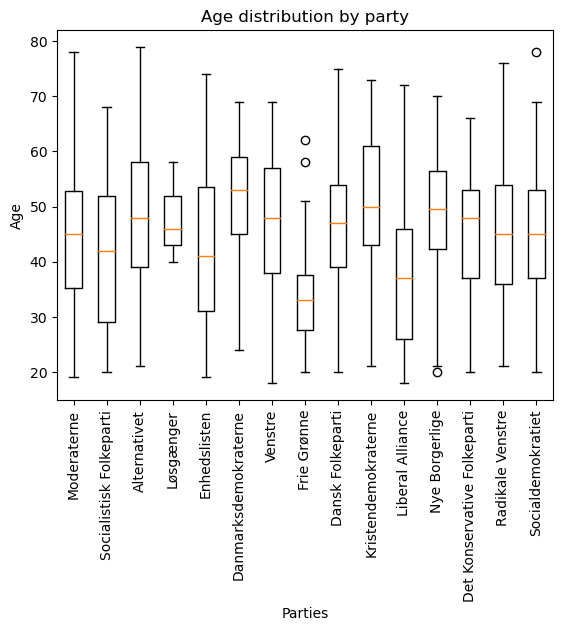

In [3]:
# Remove 0 year old people
data_filtered = clean_dataFrame[clean_dataFrame['Age'] != 0]

# - Fetch the neighborhood and price columns from the
parties = data_filtered['Party']
ages = data_filtered['Age']

# * Initialize an empty dictionary
party_ages = {}

# * Loop through each neighborhood and price
for party, age in zip(parties, ages):
    # If the neighborhood doesn't exist in the dictionary, add it with the current price in a new list
    if party not in party_ages:
        party_ages[party] = [age]
    # If the neighborhood exists, append the current price to its list
    else:
        party_ages[party].append(age)

# * Extract the lists of prices for each neighborhood in the dictionary
age_lists = list(party_ages.values())

# * Create a boxplot for price data
plt.boxplot(age_lists)

# *  Extract nieghborhood names for x-ticks
party_names = list(party_ages.keys())

# * Set points on the x-axis for each neighborhood
plt.xticks(range(1,len(party_names)+1),party_names,rotation=90)

# * Label the axises and diagram.
plt.xlabel('Parties')
plt.ylabel('Age')
plt.title('Age distribution by party')

# - Show the plot with adjustments
plt.show()

# An overview of the most "confident" candidates, i.e., those with the highest proportion of "strongly agree" or "strongly disagree" responses.

In [4]:
# Go over all the questions and add up the "strongly agree" and "strongly disagree"
# Make copy df, so not to mess up clean data
df = clean_dataFrame.copy()

# get all questions
questions = [col for col in df.columns if col.startswith('DR-') | col.startswith('TV2-')]

listOfconfidence = []
# Is the responses "strongly agree" or "strongly disagree" add to a count
for index, candidate in df.iterrows():
    confidence = 0
    for question in questions:
        if (candidate[question] == -2 or candidate[question] == 2):
            confidence+=1
    listOfconfidence.append(confidence)

df.loc[:, 'Confidence'] = listOfconfidence

ranking = df[['Name', 'Confidence']].sort_values(by='Confidence', ascending=False)

# clean_dataFrame
display(ranking)

,Name,Confidence
505,Sarah Nørris,49
88,Søren Vanting,49
559,Kim Andkjær Doberck,44
152,Rashid Ali,43
44,Mohamed Abdikarim,43
...,...,...
226,Halima El Abassi,2
509,Michael Mikkelsen,0
643,Søren Lund Hansen,0
699,Kasper Roug,0


# Differences in responses between candidates, both inter-party and intra-party, along with an explanation of which parties have the most internal disagreements.

,DR-1,DR-2,DR-3,DR-4,DR-5,DR-6,DR-7,DR-8,DR-9,DR-10,...,TV2-8a,TV2-8b,TV2-9a,TV2-9b,TV2-10a,TV2-10b,TV2-11a,TV2-11b,TV2-12a,TV2-12b
0,2.025303,2.611109,2.337928,1.922645,1.83114,2.381113,1.775337,2.313883,2.466513,2.330185,...,0.691123,0.913122,1.989175,1.027588,1.527329,2.611274,2.17398,2.570234,1.056882,1.493643


<BarContainer object of 49 artists>

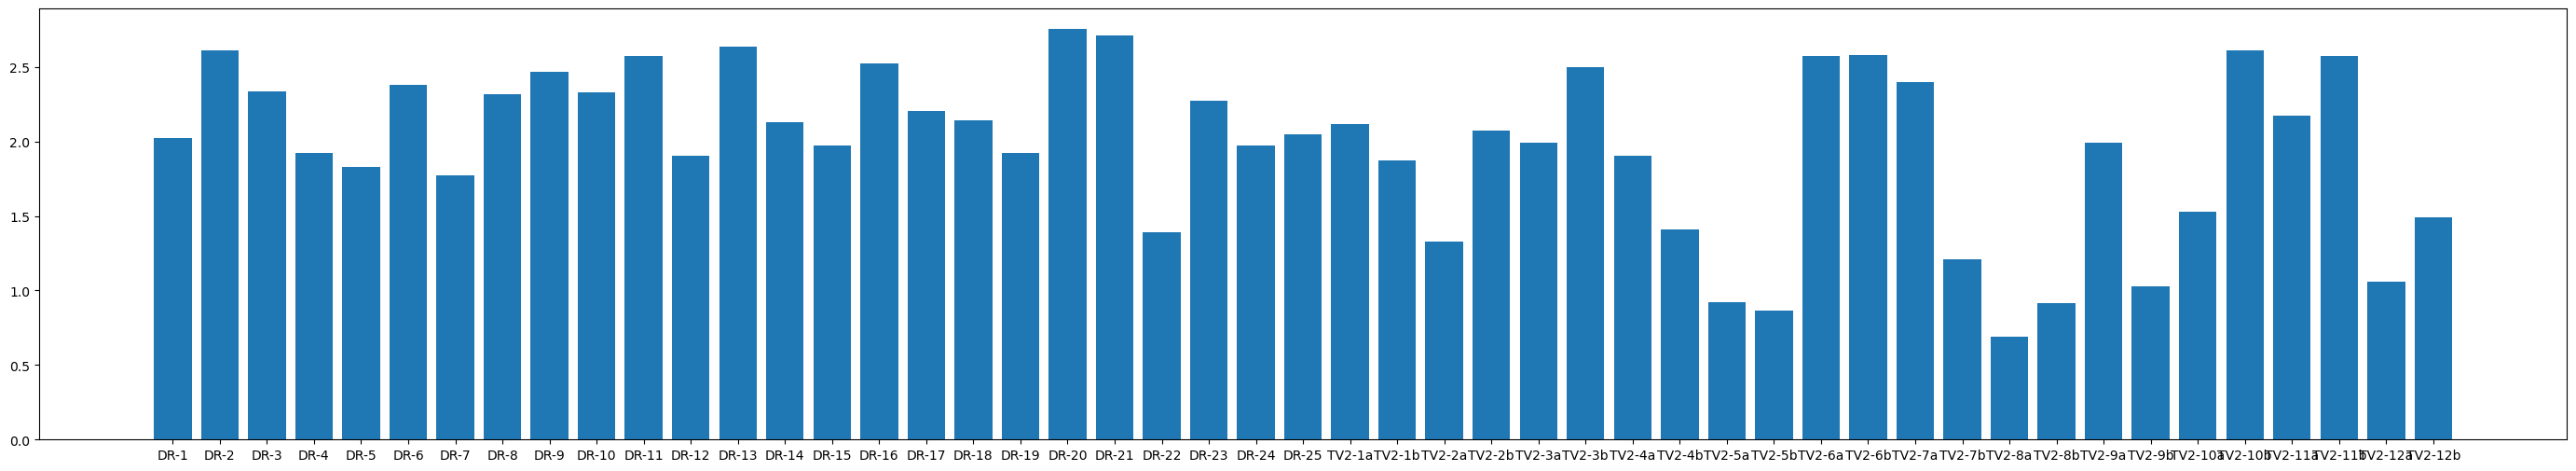

In [5]:
# Make copy df, so not to mess up clean data
df = clean_dataFrame.copy()

# find questions
questions = [col for col in df.columns if col.startswith('DR-') | col.startswith('TV2-')]


# inter-party
# find the differences/var between the candidate foreach question
differences = []

data = {}

for question in questions:
    data[question] = df[question].var()
    differences.append(df[question].var())
    
df_var = pd.DataFrame(data, index=[0])

display(df_var)

plt.figure(figsize=(35, 6))
plt.bar(questions, differences)

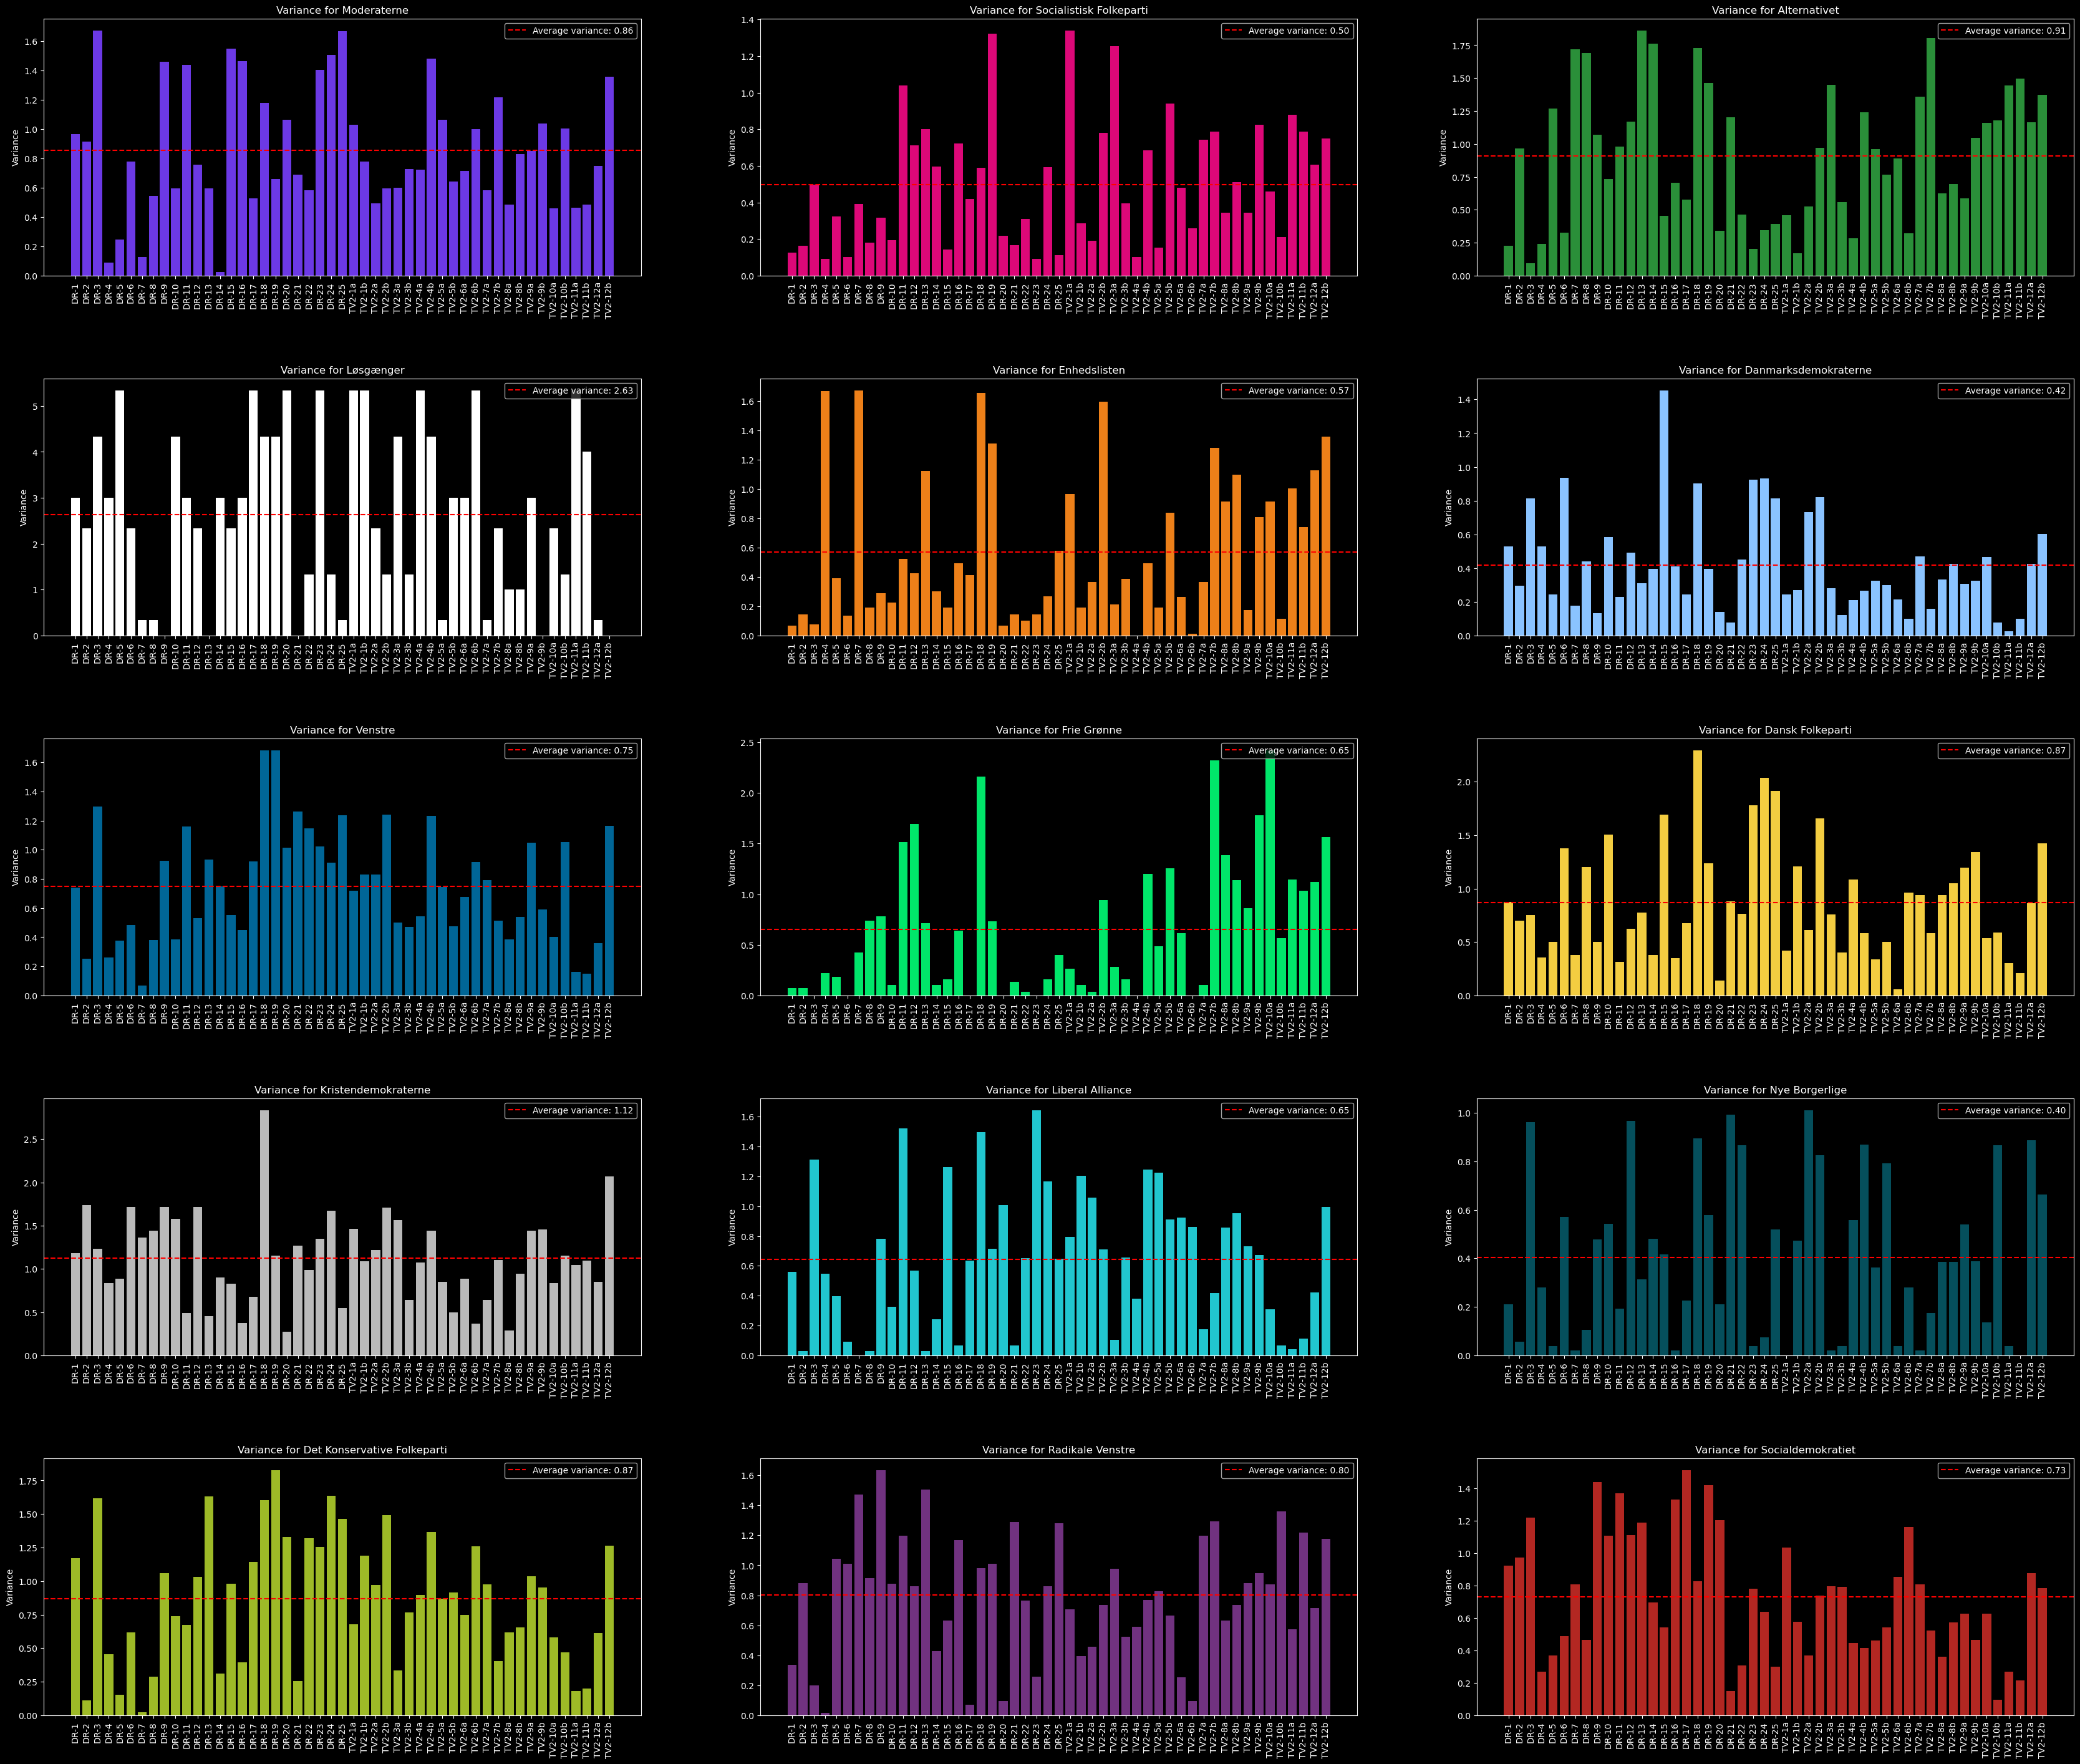

In [6]:
import numpy as np

# Utility function - Colors for the different parties
def party_colors() -> dict:
    return {
        'Moderaterne': '#6c39e5',
        'Socialistisk Folkeparti': '#dd0878',
        'Alternativet': '#2a8f39',
        'Løsgænger': 'white',
        'Enhedslisten': '#ed8019',
        'Danmarksdemokraterne': '#8ac3ff',
        'Venstre': '#006697',
        'Frie Grønne': '#00e66a',
        'Dansk Folkeparti': '#f3cd41',
        'Kristendemokraterne': '#bababa',
        'Liberal Alliance': '#21c6cf',
        'Nye Borgerlige': '#054f5c',
        'Det Konservative Folkeparti': '#9eba27',
        'Radikale Venstre': '#713280',
        'Socialdemokratiet': '#b32722'
    }

# - Fetch the necessary data
selected_data = clean_dataFrame[['Name', 'Party'] + [col for col in clean_dataFrame.columns if 'DR' in col or 'TV2' in col]]

# - Find the questions
responses = [col for col in selected_data.columns if 'DR' in col or 'TV2' in col]

# - Find the parties
parties = selected_data['Party'].unique()
party_colors = party_colors()

# * Initialize the empty dictionary
data = {}

# ! Iterate through the responses and populate the dictionary
for response in responses:
    # * Calculate the variance for each response
    for party in parties:
        # * Extract the data for the specific party
        party_data = selected_data[selected_data['Party'] == party]

        # * Calculate the variance for the party
        variance = party_data[response].var()

        # ? Update the dictionary
        if party in data:
            data[party][response] = variance
        else:
            data[party] = {response: variance}


# * Calculate the number of rows and columns for the subplots
n_parties = len(parties)
n_cols = 3
n_rows = np.ceil(n_parties / n_cols).astype(int)

# * Create the subplots
plt.style.use('dark_background') 
fig, axs = plt.subplots(n_rows, n_cols, figsize=(14 * n_cols, 8 * n_rows))  # Adjust the figure size as needed

# * Flatten the axis array for easy indexing
axs = axs.flatten()

# ? Iterate through the parties and plot the variance
for idx, party in enumerate(parties):
    df_var = pd.DataFrame(data[party], index=[0])
    df_var_transposed = df_var.T
    df_var_transposed[0] = df_var_transposed[0].astype(float)
    
    # * Plot on the respective subplot
    ax = axs[idx]
    ax.bar(df_var_transposed.index, df_var_transposed[0], color=party_colors[party])
    
    # * Calculate the average and add a line to the plot
    average_variance = df_var_transposed[0].mean()
    ax.axhline(y=average_variance, color='r', linestyle='--', label=f'Average variance: {average_variance:.2f}')
    
    # ? Style the plot
    ax.set_title(f'Variance for {party}')
    ax.tick_params(axis='x', rotation=90)
    ax.set_ylabel('Variance')
    ax.legend(loc="upper right")

# * Hide any unused axes
for idx in range(n_parties, n_rows * n_cols):
    axs[idx].set_visible(False)

# * Adjust layout to prevent overlap
fig.subplots_adjust(bottom=0.2, hspace=0.4)

# - Display the plot
plt.show()




# Most internal disagreements.
The party with the most internal disagreement is Kristendemokraterne, which is reflected by their highest average variance of 1.12 among all the parties. Following them, Alternativet holds the position of having the second most internal disagreement, with a variance of 0.92. While some might argue that Løsgænger exhibits a higher variance, at 2.63, it's important to note that Løsgænger is not considered a formal party. Given that it consists of only three members, their political opinions do not necessarily need to align. Therefore, for the purpose of this analysis, they are not included in the comparison of formal parties.

Classification models to predict candidates' party affiliations. Investigate if there are any candidates who seem to be in the "wrong" party based on their political landscape positions. You must use the following three algorithms: **Decision Tree, Random Forrest, and Gradient Boosted Tree**, and **two other** classification algorithms of your choice.

In [7]:
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import DecisionTreeClassifier
# - Fetch the necessary data
data = clean_dataFrame.copy()

# Utility function - Find the median age for each party as dictionary
def median_age(data : pd.DataFrame) -> dict:
    # * Initialize the empty dictionary
    median_ages = {}

    # ! Iterate through the data and populate the dictionary
    for party in data['Party'].unique():
        # * Extract the data for the specific party
        party_data = data[data['Party'] == party]

        # * Calculate the median age for the party
        median_ages[party] = party_data['Age'].median()

    return median_ages

# ! Impute the missing ages with the median age for the respective party
# So we can use the age in the analysis.
median_ages = median_age(data)
for party, median_age in median_ages.items():
    data.loc[data['Party'] == party, 'Age'].fillna(median_age)

# Utility function - Remove 'Løsgænger' from the data
def remove_losgaenger(data : pd.DataFrame) -> pd.DataFrame:
    return data[data['Party'] != 'Løsgænger']

# ! Remove 'Løsgænger' from the data
# Since it's not a party, we can't predict if a candidate is a 'Løsgænger' or not
data = remove_losgaenger(data)

# ! Remove 'Name' and from the data
# Since it's not a feature that can be used to predict the party
data = data.drop('Name', axis=1)

# - Preparing feature and target variables
X = data.drop('Party', axis=1) 
y = data['Party']

# * Encode categorical variables and impute any missing values if necessary
categorical_features = ['District']
numeric_features = X.drop(columns=categorical_features).columns.tolist()

# # Preprocessing for numerical features: no imputation needed beyond age adjustment already done
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median'))
])

# # Preprocessing for categorical features: encode 'storkreds'
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# ! Combine preprocessing for both numeric and categorical features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# - Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Decision Tree

## Find best input

In [8]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
import graphviz

# - Create preprocessing and modeling pipeline
model = Pipeline(steps=[('preprocessor', preprocessor),
                        ('classifier', DecisionTreeClassifier(max_depth=9, random_state=42))])

# * Fit the classifier to the training data
model.fit(X_train, y_train)

param_grid = {
    'classifier__max_depth': [1,2,3,4,5,6,7,8,9,10,11,12,13,14],
}

# Setup GridSearchCV with your model2 pipeline and the parameter grid
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy', verbose=1)

grid_search.fit(X_train, y_train)

# Best parameters and best score found by GridSearchCV
best_params = grid_search.best_params_
best_score = grid_search.best_score_

# Evaluating the best model found by GridSearchCV on the test data
optimized_score = grid_search.score(X_test, y_test)

# Display the best parameters, best cross-validation score, and test score
print("Best Parameters:", best_params)
print("Best Cross-Validation Score:", best_score)
print("Optimized Score on Test Data:", optimized_score)

Fitting 5 folds for each of 14 candidates, totalling 70 fits
Best Parameters: {'classifier__max_depth': 9}
Best Cross-Validation Score: 0.7047648837451779
Optimized Score on Test Data: 0.7745664739884393


## Run model on best input

Accuracy on training set: 0.977
Accuracy on test set: 0.775


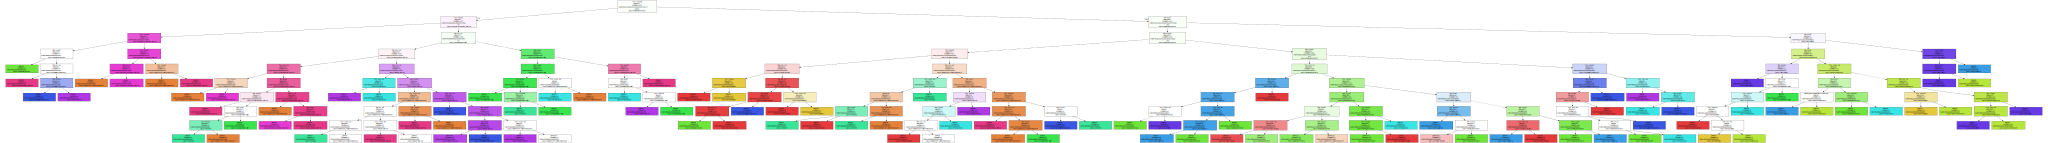

In [9]:
# - Create preprocessing and modeling pipeline
model = Pipeline(steps=[('preprocessor', preprocessor),
                        ('classifier', DecisionTreeClassifier(max_depth=9, random_state=42))])

# * Fit the classifier to the training data
model.fit(X_train, y_train)

# - Print the accuracy
print("Accuracy on training set: {:.3f}".format(model.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(model.score(X_test, y_test)))

# - Create a graph of the decision tree
transformed_columns = numeric_features + list(model.named_steps['preprocessor'].transformers_[1][1].named_steps['onehot'].get_feature_names_out())

# * Extract the tree
tree = model.named_steps['classifier']

# * Export the tree to a dot file
dot_data = export_graphviz(tree, out_file=None, feature_names=transformed_columns, class_names=y_test.unique(), filled=True, special_characters=True)

# * Display the graph
graph = graphviz.Source(dot_data)

# Change the size of the graph
graph.render('tree', cleanup=True)

# - Display the graph
graph

# Random Forrest

## Find best input

In [10]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# - Create preprocessing and modeling pipeline
model = Pipeline(steps=[('preprocessor', preprocessor),
                        ('classifier', RandomForestClassifier(n_estimators = 200, max_depth = 8, max_features = 14, random_state = 42))])

# * Fit the classifier to the training data
model.fit(X_train, y_train)

param_grid = {
    'classifier__n_estimators': [100, 150, 200, 250],
    'classifier__max_depth': [6,7,8,9,10,11,12,13,14],
    'classifier__max_features': [6,7,8,9,10,11,12,13,14],
}

# Setup GridSearchCV with your model2 pipeline and the parameter grid
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy', verbose=1)

grid_search.fit(X_train, y_train)

# Best parameters and best score found by GridSearchCV
best_params = grid_search.best_params_
best_score = grid_search.best_score_

# Evaluating the best model found by GridSearchCV on the test data
optimized_score = grid_search.score(X_test, y_test)

# Display the best parameters, best cross-validation score, and test score
print("Best Parameters:", best_params)
print("Best Cross-Validation Score:", best_score)
print("Optimized Score on Test Data:", optimized_score)

Fitting 5 folds for each of 324 candidates, totalling 1620 fits
Best Parameters: {'classifier__max_depth': 9, 'classifier__max_features': 8, 'classifier__n_estimators': 200}
Best Cross-Validation Score: 0.9001251172974664
Optimized Score on Test Data: 0.9421965317919075


## Run model on best input

In [12]:
# - Create preprocessing and modeling pipeline
model = Pipeline(steps=[('preprocessor', preprocessor),
                        ('classifier', RandomForestClassifier(n_estimators = 200, max_depth = 9, max_features = 8, random_state = 42))])

# * Fit the classifier to the training data
model.fit(X_train, y_train)


print("Train accuracy: {}".format(model.score(X_train, y_train)))
print("Test accuracy: {}".format(model.score(X_test, y_test)))

Train accuracy: 0.9985528219971056
Test accuracy: 0.9421965317919075


# Gradient Boosted Tree

In [13]:
from sklearn.ensemble import GradientBoostingClassifier
model = Pipeline(steps=[('preprocessor', preprocessor),
                        ('classifier', GradientBoostingClassifier(random_state = 42, n_estimators = 100,
                                max_depth = 6, learning_rate = 0.01))])

model.fit(X_train, y_train)

print("Train accuracy: {}".format(model.score(X_train, y_train)))
print("Test accuracy: {}".format(model.score(X_test, y_test)))

Train accuracy: 1.0
Test accuracy: 0.7687861271676301


# **two other** classification algorithms of your choice.

# logistic regression

## Find best input

In [14]:
from sklearn.linear_model import LogisticRegression

# - Create preprocessing and modeling pipeline
model = Pipeline(steps=[('preprocessor', preprocessor),('classifier', LogisticRegression(max_iter=10000))])

# * Fit the classifier to the training data
model.fit(X_train, y_train)

# - Param grid for grid search
param_grid = {
    'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100],
    'classifier__max_iter': [10000, 20000, 30000]
}

# * Perform grid search
grid_search = GridSearchCV(model, param_grid, cv=5, scoring="accuracy")

# * Fit the grid search to the data
grid_search.fit(X_train, y_train)

# * Display the best parameters, best cross-validation score, and test score
print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validation Score:", grid_search.best_score_)

# - Print the accuracy
print("Accuracy on training set: {:.3f}".format(model.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(model.score(X_test, y_test)))

Best Parameters: {'classifier__C': 0.01, 'classifier__max_iter': 10000}
Best Cross-Validation Score: 0.8957877176519654
Accuracy on training set: 0.994
Accuracy on test set: 0.925


## Run model on best input

In [15]:
# - Create preprocessing and modeling pipeline
model = Pipeline(steps=[('preprocessor', preprocessor),
                        ('classifier', LogisticRegression(max_iter=10000, C=0.01))])

model.fit(X_train, y_train)

print("Train accuracy: {}".format(model.score(X_train, y_train)))
print("Test accuracy: {}".format(model.score(X_test, y_test)))

Train accuracy: 0.9421128798842258
Test accuracy: 0.9248554913294798


# KNeighbors

## Find best input

In [16]:
from sklearn.neighbors import KNeighborsClassifier
# - Create preprocessing and modeling pipeline
model = Pipeline(steps=[('preprocessor', preprocessor),
                        ('classifier', KNeighborsClassifier(n_neighbors=3, weights='uniform'))])

model.fit(X_train, y_train)

param_grid = {
    'classifier__n_neighbors': [3, 5, 7, 9, 11],
    'classifier__weights': ['uniform', 'distance'],
  
}

# Setup GridSearchCV with your model2 pipeline and the parameter grid
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy', verbose=1)

grid_search.fit(X_train, y_train)

# Best parameters and best score found by GridSearchCV
best_params = grid_search.best_params_
best_score = grid_search.best_score_

# Evaluating the best model found by GridSearchCV on the test data
optimized_score = grid_search.score(X_test, y_test)

# Display the best parameters, best cross-validation score, and test score
print("Best Parameters:", best_params)
print("Best Cross-Validation Score:", best_score)
print("Optimized Score on Test Data:", optimized_score)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Parameters: {'classifier__n_neighbors': 5, 'classifier__weights': 'distance'}
Best Cross-Validation Score: 0.7901678657074341
Optimized Score on Test Data: 0.8554913294797688


## Run model on best input

In [17]:
# - Create preprocessing and modeling pipeline
model = Pipeline(steps=[('preprocessor', preprocessor),
                        ('classifier', KNeighborsClassifier(n_neighbors=5, weights='distance'))])

model.fit(X_train, y_train)

print("Train accuracy: {}".format(model.score(X_train, y_train)))
print("Test accuracy: {}".format(model.score(X_test, y_test)))

Train accuracy: 1.0
Test accuracy: 0.8554913294797688


# Investigate if there are any candidates who seem to be in the "wrong" party based on their political landscape positions.

Given that the RandomForest algorithm has proven to be the most effective, it is advisable to employ this model to ascertain whether a candidate is misaligned with their political party.

In [19]:
# - Create preprocessing and modeling pipeline
model = Pipeline(steps=[('preprocessor', preprocessor),
                        ('classifier', RandomForestClassifier(n_estimators = 200, max_depth = 8, max_features = 14, random_state = 42))])

# * Fit the classifier to the training data
model.fit(X_train, y_train)

predicted_data = data.copy()

predicted_values = model.predict(data)

predicted_data['Predicted'] = predicted_values
predicted_data['Name'] = clean_dataFrame['Name']

predicted_data = predicted_data.drop(questions + ['District', 'Age'], axis=1)

display(predicted_data[predicted_data['Party'] != predicted_data['Predicted']])

,Party,Predicted,Name
120,Alternativet,Radikale Venstre,Mette Kaasfeldt Bram
139,Venstre,Det Konservative Folkeparti,Linea Søgaard-Lidell
140,Venstre,Det Konservative Folkeparti,Bo Sandroos
333,Alternativet,Enhedslisten,Henrik Boye
334,Alternativet,Radikale Venstre,Ole Dupont Kofod
335,Alternativet,Frie Grønne,Simon Nyborg Jensen
336,Enhedslisten,Socialistisk Folkeparti,Niels Bjarne Lund
379,Nye Borgerlige,Det Konservative Folkeparti,Lars Sternkopf Lillebæk
653,Kristendemokraterne,Socialdemokratiet,Finn Andersen
678,Det Konservative Folkeparti,Venstre,Jacob Stryhn
